In [579]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12

from scipy.signal import lfilter, butter
from scipy.linalg import eigh

from sklearn.cluster import KMeans

import nibabel as nib
import os

from tqdm.auto import tqdm

folder = '/data/facca/'

TR = 0.72
lfreq = 0.008
hfreq = 0.08

cmap = 'coolwarm'

In [562]:
def bp_filter(data, lfreq=lfreq, hfreq=hfreq, TR=TR):
    b, a = butter(2, np.array([lfreq, hfreq])*2*TR, btype='band')
    return lfilter(b, a, data)

In [563]:
def load_data(subj, demean=True):
    data = []

    for fname in os.listdir(folder):
        if str(subj) in fname:
            print(fname)
            tmp = nib.load(folder+fname).get_fdata().T
            if demean:
                data.append(tmp-tmp.mean(axis=1,keepdims=True))
            else:
                data.append(tmp)
            
    return data

In [528]:
### Get subjects names
subjs = []

for fname in os.listdir(folder):
    if 'REST1.LR' in fname:
        subjs.append(int(fname.split('.')[0]))
        
print('N subjects:', len(subjs))

N subjects: 20


In [494]:
data = load_data(subjs[1], demean=False)

352132.REST1.LR.Schaefer.ptseries.nii
352132.REST1.RL.Schaefer.ptseries.nii
352132.REST2.LR.Schaefer.ptseries.nii
352132.REST2.RL.Schaefer.ptseries.nii


In [495]:
demeaned = [tmp-tmp.mean(axis=1,keepdims=True) for tmp in data]
filtered = [bp_filter(tmp) for tmp in demeaned]

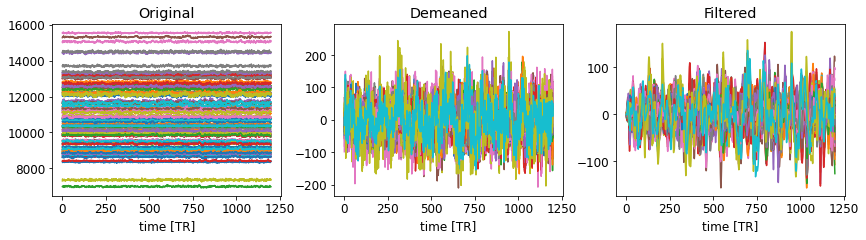

In [496]:
plt.figure(figsize=(12,3.5))

plt.subplot(1,3,1)
plt.plot(data[0].T)
plt.title('Original')
plt.xlabel('time [TR]')

plt.subplot(1,3,2)
plt.plot(demeaned[0].T)
plt.title('Demeaned')
plt.xlabel('time [TR]')

plt.subplot(1,3,3)
plt.plot(filtered[0].T)
plt.title('Filtered')
plt.xlabel('time [TR]')

plt.tight_layout()
plt.show()

In [484]:
bold = filtered[0]
N, Tmax = bold.shape
print(N, Tmax)

fc = np.corrcoef(bold)

100 1200


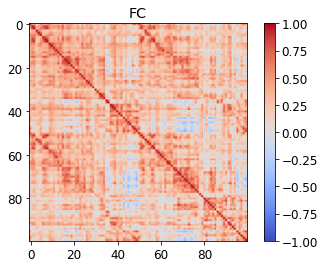

In [485]:
plt.imshow(fc, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar()
plt.title('FC')
plt.show()

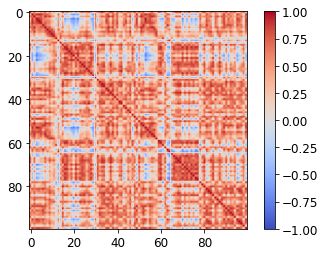

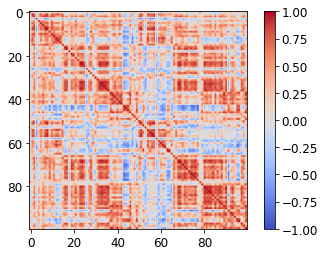

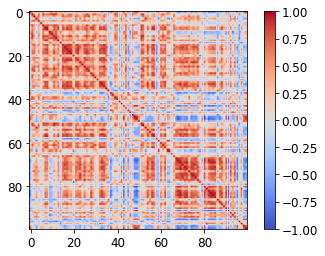

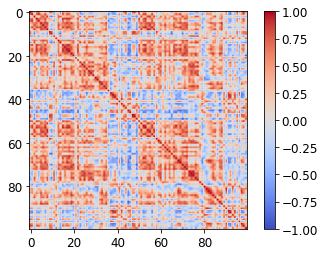

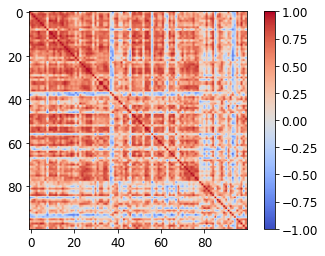

In [486]:
window = 50
shift = 50

for tt in range(5):
    tmp = bold[:,tt*shift:tt*shift+window]
    plt.imshow(np.corrcoef(tmp), cmap=cmap, vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

In [580]:
def compute_dfc(bold, window=80, shift=18, zscore=True, compute_eig=False):
    N, Tmax = bold.shape
    n_fcd = (Tmax - window) // shift
    
    dfc = np.zeros((n_fcd,n_fcd))
    reduced = np.zeros((n_fcd, N*(N-1)//2))
    idx = np.triu_indices(N,1)

    for i in tqdm(range(n_fcd-1)):            
        tmp_X = bold[:,i*shift:i*shift+window]
        tmp_X = np.corrcoef(tmp_X)
        
        if compute_eig:
            # z-score FC(t)
            if zscore:
                tmp = np.arctanh(tmp_X)
                tmp[np.isnan(tmp)] = 0
                tmp[np.isinf(tmp)] = 0
                eigvals, eigvec = eigh(tmp)
            else:
                eigvals, eigvec = eigh(tmp_X)
                                
            # Compute largest eigenvector
            eigvec = eigvec[np.argmax(eigvals)]
            eigvec = eigvec[:,None] * eigvec
            reduced[i] = eigvec[idx]
            
            '''
            plt.imshow(tmp_X, cmap=cmap)
            plt.colorbar()
            plt.show()
            plt.imshow(eigvec, cmap=cmap)
            plt.colorbar()
            plt.show()
            '''
            
        tmp_X = tmp_X[idx]
    
        for j in range(i+1,n_fcd):
            tmp_Y = bold[:,j*shift:j*shift+window]
            tmp_Y = np.corrcoef(tmp_Y)[idx]
        
            dfc[i,j] = np.corrcoef(tmp_X, tmp_Y)[0,1]
        
    dfc += dfc.T + np.eye(n_fcd)
    
    return dfc, reduced

In [488]:
dfc, reduced = compute_dfc(bold)

  0%|          | 0/61 [00:00<?, ?it/s]

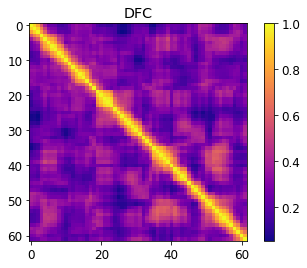

In [489]:
plt.imshow(dfc, cmap='plasma', interpolation='none')
plt.title('DFC')
plt.colorbar()
plt.show()

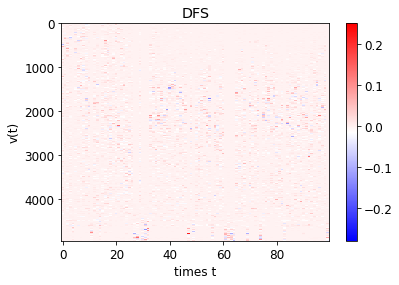

In [388]:
plt.imshow(reduced[:100].T, cmap='bwr', aspect='auto', interpolation='none')
plt.colorbar()
plt.ylabel('v(t)')
plt.xlabel('times t')
plt.title('DFS')
plt.show()

In [419]:
# K-means clustering
fitter = KMeans(n_clusters=4).fit(res_concat)

In [420]:
centroids  = fitter.cluster_centers_

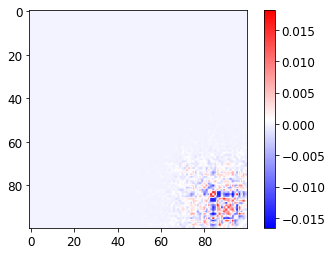

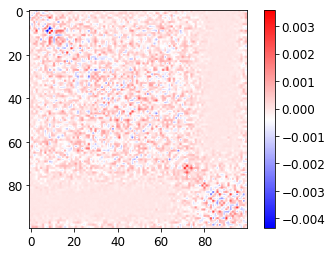

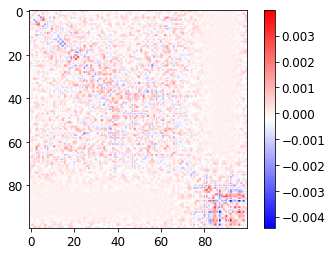

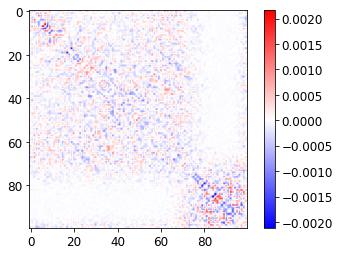

In [421]:
for tmp in centroids:
    # Reconstruct matrix
    mat = np.zeros((N,N))
    idx = np.triu_indices(N,1)
    mat[idx] = tmp
    mat += mat.T
    
    plt.imshow(mat, cmap='bwr')
    plt.colorbar()
    plt.show()

In [581]:
ress = []

for i, subj in enumerate(subjs):
    print(f'#### {i+1}/{len(subjs)}')
    
    ### Load data
    print('Load data...')
    data = load_data(subj)
    
    ### Keep only one-session
    '''
    if i<len(subjs)//2:
        data = data[0]
    else:
        data = data[1]
    '''

    ### Band-pass filter
    data = [bp_filter(tmp) for tmp in data]
    
    ### Computing DFC
    print('Computing DFC...')
    dfc = [compute_dfc(tmp)[0] for tmp in data]
    
    ress.append(dfc)

#### 1/20
Load data...
352132.REST1.LR.Schaefer.ptseries.nii
352132.REST1.RL.Schaefer.ptseries.nii
352132.REST2.LR.Schaefer.ptseries.nii
352132.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 2/20
Load data...
352738.REST1.LR.Schaefer.ptseries.nii
352738.REST1.RL.Schaefer.ptseries.nii
352738.REST2.LR.Schaefer.ptseries.nii
352738.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 3/20
Load data...
353740.REST1.LR.Schaefer.ptseries.nii
353740.REST1.RL.Schaefer.ptseries.nii
353740.REST2.LR.Schaefer.ptseries.nii
353740.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 4/20
Load data...
358144.REST1.LR.Schaefer.ptseries.nii
358144.REST1.RL.Schaefer.ptseries.nii
358144.REST2.LR.Schaefer.ptseries.nii
358144.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 5/20
Load data...
406836.REST1.LR.Schaefer.ptseries.nii
406836.REST1.RL.Schaefer.ptseries.nii
406836.REST2.LR.Schaefer.ptseries.nii
406836.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 6/20
Load data...
433839.REST1.LR.Schaefer.ptseries.nii
433839.REST1.RL.Schaefer.ptseries.nii
433839.REST2.LR.Schaefer.ptseries.nii
433839.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 7/20
Load data...
500222.REST1.LR.Schaefer.ptseries.nii
500222.REST1.RL.Schaefer.ptseries.nii
500222.REST2.LR.Schaefer.ptseries.nii
500222.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 8/20
Load data...
512835.REST1.LR.Schaefer.ptseries.nii
512835.REST1.RL.Schaefer.ptseries.nii
512835.REST2.LR.Schaefer.ptseries.nii
512835.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 9/20
Load data...
555348.REST1.LR.Schaefer.ptseries.nii
555348.REST1.RL.Schaefer.ptseries.nii
555348.REST2.LR.Schaefer.ptseries.nii
555348.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 10/20
Load data...
559053.REST1.LR.Schaefer.ptseries.nii
559053.REST1.RL.Schaefer.ptseries.nii
559053.REST2.LR.Schaefer.ptseries.nii
559053.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 11/20
Load data...
568963.REST1.LR.Schaefer.ptseries.nii
568963.REST1.RL.Schaefer.ptseries.nii
568963.REST2.LR.Schaefer.ptseries.nii
568963.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 12/20
Load data...
581450.REST1.LR.Schaefer.ptseries.nii
581450.REST1.RL.Schaefer.ptseries.nii
581450.REST2.LR.Schaefer.ptseries.nii
581450.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 13/20
Load data...
599671.REST1.LR.Schaefer.ptseries.nii
599671.REST1.RL.Schaefer.ptseries.nii
599671.REST2.LR.Schaefer.ptseries.nii
599671.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 14/20
Load data...
601127.REST1.LR.Schaefer.ptseries.nii
601127.REST1.RL.Schaefer.ptseries.nii
601127.REST2.LR.Schaefer.ptseries.nii
601127.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 15/20
Load data...
660951.REST1.LR.Schaefer.ptseries.nii
660951.REST1.RL.Schaefer.ptseries.nii
660951.REST2.LR.Schaefer.ptseries.nii
660951.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 16/20
Load data...
662551.REST1.LR.Schaefer.ptseries.nii
662551.REST1.RL.Schaefer.ptseries.nii
662551.REST2.LR.Schaefer.ptseries.nii
662551.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 17/20
Load data...
665254.REST1.LR.Schaefer.ptseries.nii
665254.REST1.RL.Schaefer.ptseries.nii
665254.REST2.LR.Schaefer.ptseries.nii
665254.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 18/20
Load data...
667056.REST1.LR.Schaefer.ptseries.nii
667056.REST1.RL.Schaefer.ptseries.nii
667056.REST2.LR.Schaefer.ptseries.nii
667056.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 19/20
Load data...
679770.REST1.LR.Schaefer.ptseries.nii
679770.REST1.RL.Schaefer.ptseries.nii
679770.REST2.LR.Schaefer.ptseries.nii
679770.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

#### 20/20
Load data...
680957.REST1.LR.Schaefer.ptseries.nii
680957.REST1.RL.Schaefer.ptseries.nii
680957.REST2.LR.Schaefer.ptseries.nii
680957.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [582]:
ress = [item for sublist in ress for item in sublist]

In [583]:
dfc_mean = np.mean(ress, axis=0)

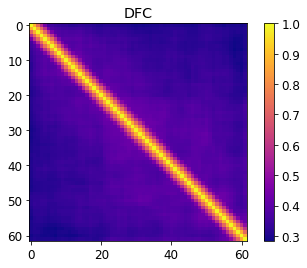

In [584]:
plt.imshow(dfc_mean, cmap='plasma', interpolation='none')
plt.title('DFC')
plt.colorbar()
plt.show()

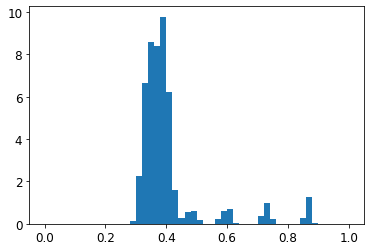

In [548]:
plt.hist(dfc_mean[np.triu_indices(dfc_mean.shape[0],1)], range=(0,1), bins=50, density=True)
plt.show()

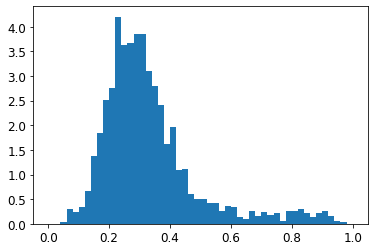

In [550]:
plt.hist(ress[0][np.triu_indices(dfc_mean.shape[0],1)], range=(0,1), bins=50, density=True)
plt.show()

In [585]:
distr = np.array([tmp[np.triu_indices(dfc_mean.shape[0],1)] for tmp in ress]).flatten()

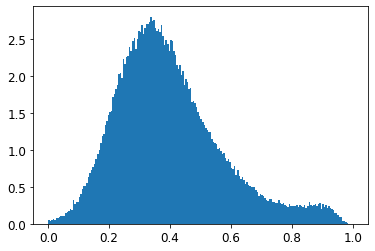

In [586]:
plt.hist(distr, range=(0,1), bins=200, density=True)
plt.show()

In [587]:
np.save('results/DFC_hist.npy', distr)